In [1]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.81

# Fuel Mass Fraction Analysis
For the analysis the following equation is considered

$$
W_0 = W_{\mathrm{PAX}} + W_\mathrm{e} + W_\mathrm{f}
$$

which can be extended to

$$
W_0 = W_{\mathrm{PAX}} + \frac{W_\mathrm{e}}{W_0}W_0 + \frac{W_\mathrm{f}}{W_0}W_0
$$

which can be rewritten to

$$
W_0 (1 - \frac{W_\mathrm{e}}{W_0}- \frac{W_\mathrm{f}}{W_0}) = W_{\mathrm{PAX}}
$$

and

$$
W_0 = \frac{W_{\mathrm{PAX}}}{1 - \frac{W_\mathrm{e}}{W_0}- \frac{W_\mathrm{f}}{W_0}} \; .
$$

# Assumptions
For the S1 a hybrid engine with HTTP as solid fuel and $\mathrm{N}_2 \mathrm{O}$ as oxidator is assumed.
The following assumptions are made

| c_e (sea level) | Oxidator / Fuel | Cargo  | W_e / W_0| T / W |
| --------------- | :-------------: | ------ | :------: | :---: |
| 2452.5 m/s      | 7.1             | 300 kg | 1/3      | 2     |

In [2]:
c_e = 2452.98
O2F = 7.1
Wpax = 300
We2W0 = 0.32
T2W = 2.0

def calc_W0(Wf2W0):
    return Wpax / (1.0 - We2W0 - Wf2W0)

def calc_T(W0):
    return T2W * W0 * g

def calc_m_dot(T):
    return T / (c_e)

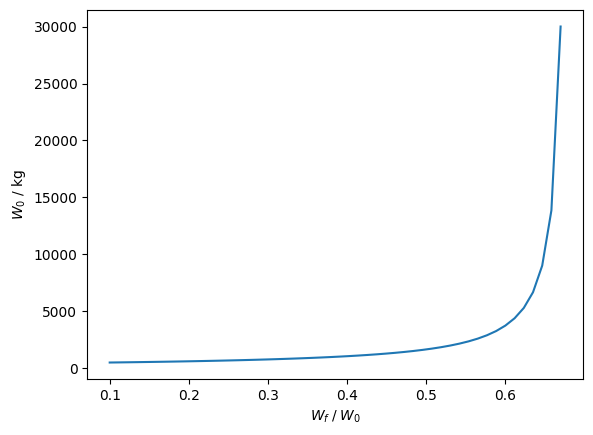

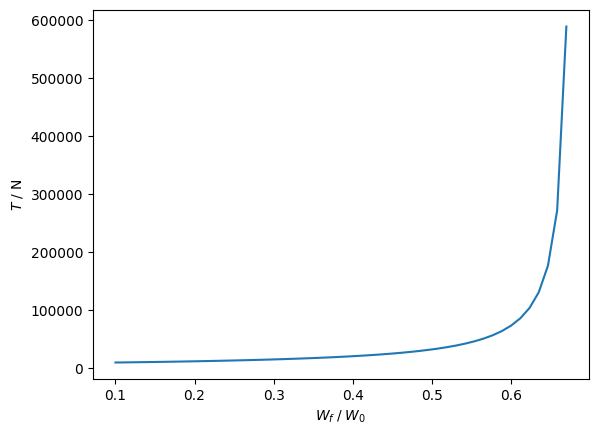

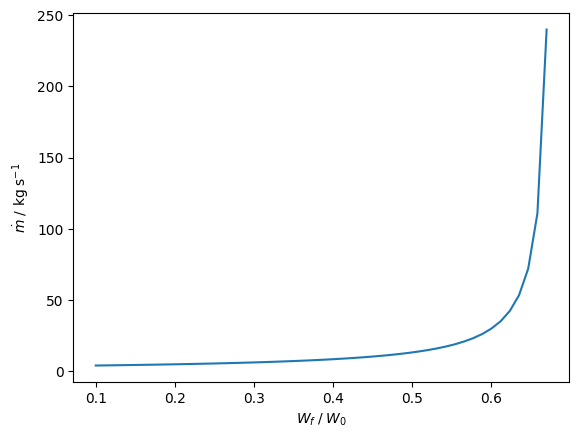

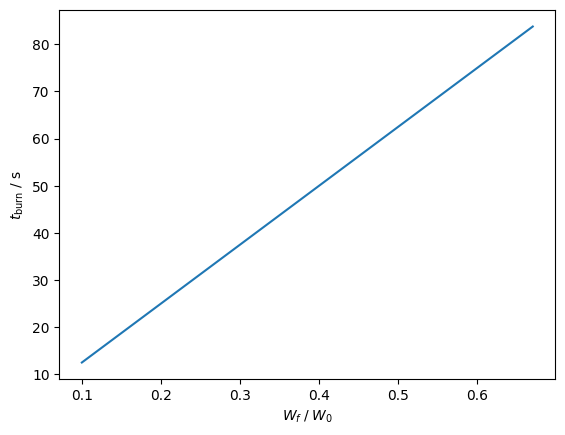

In [3]:
Wf2W0min = 0.1
Wf2W0max = 1 - We2W0 - 0.01
Wf2W0 = np.linspace(Wf2W0min, Wf2W0max)

W0 = []
T = []
m_dot = []
t_burn = []

for wf in Wf2W0:
    W0.append(calc_W0(wf))
    T.append(calc_T(W0[-1]))
    m_dot.append(calc_m_dot(T[-1]))
    t_burn.append(W0[-1]*wf / m_dot[-1])
    
plt.plot(Wf2W0, W0)
plt.xlabel("$W_f \;/\; W_0$")
plt.ylabel("$W_0$ / kg")

plt.show()

plt.plot(Wf2W0, T)
plt.xlabel("$W_f \;/\; W_0$")
plt.ylabel("$T$ / N")

plt.show()

plt.plot(Wf2W0, m_dot)
plt.xlabel("$W_f \;/\; W_0$")
plt.ylabel("$\dot{m}$ / $\mathrm{kg}\; \mathrm{s}^{-1}$")

plt.show()

plt.plot(Wf2W0, t_burn)
plt.xlabel("$W_f \;/\; W_0$")
plt.ylabel("$t_{\mathrm{burn}}$ / $\mathrm{s}$")

plt.show()

# Simulation
The precalculation is performed on the basis of the following equation

$$
m \cdot \ddot{x} = T - D - m \cdot g
$$

where $m$ is the mass $\ddot{x}$ the acceleration $T$ the thrust and $D$ the drag.
The thrust for a rocket motor can be written as

$$
T = c_e \cdot \dot{m} \cdot \mu
$$

where $c_e$ is the exit velocity, $\dot{m}$ the mass flow ratem, and $\mu$ efficiency loss due to divergence at the nozzle as well as over or underexpansion.
The mass of the rocket can can be calculated as

$$
m = m_0 - \int_{t_0}^t \dot{m} \, \mathrm{d}\tau \;.
$$

Assuming a constant mass flow and $t_0 = 0$ the equation becomes

$$
m = m_0 - t \cdot \dot{m} \;.
$$

The drag can be modelled as

$$
D = C_D \cdot q \cdot S
$$

where $C_D$ is the drag coefficient, $q = \frac{1}{2} \rho v^2$ the dynamic pressure, and $S$ the reference wind area.

In [4]:
R = 287.05

# rho in the troposphere
def rho_tropo(h):
    rho0 = 1.225 # kg / m³
    n = 1.235
    T0 = 288.15
    
    return rho0*(1.0 - ((n - 1.0)/n)*(g/(R*T0))*h)**(1.0/(n - 1.0))

# rho in the stratosphere
def rho_strato(h):
    rhoi = 0.3639
    hi = 11000.0
    Ti = 216.65
    
    return rhoi * np.exp(-(g/(R*Ti))*(h - hi))

def rho(h):
    if h < 11000:
        return rho_tropo(h)
    else:
        return rho_strato(h)

def drag(h, v, S, c_d):
    q = 0.5*rho(h)*v*v
    return q*S*c_d

def simulation(W0, Wf2W0, m_dot, c_D, S, dt=1e-2):
    g = 9.81
    m_0 = W0 # total initial mass kg
    m_f = W0*Wf2W0 # fual mass in kg
    c_e = 2530.98 # exit velocity in m/s
    mu_b = 0.9 # burned fuel fraction used for take off and upright setting
    m = m_0 * mu_b

    a = [0]
    v = [0]
    h = [0]
    t = [0]
    q = [0]
    
    h_max = 0

    while h[-1] >= 0.0:   
        if m <= (m_0 - m_f):
            m_dot = 0.0
        
        T = c_e * m_dot
        D = (-1)**(1 - int(v[-1] >= 0.0)) * drag(h[-1], v[-1], S, c_D)
        m -= dt*m_dot
    
        t.append(t[-1] + dt)
        a.append(T/m - D/m - g)
        h.append(h[-1] + dt*v[-1] + 0.5*a[-1]*dt*dt)
        v.append(v[-1] + dt*a[-1])
        q.append(0.5*rho(h[-1])*v[-1]**2)
        
        if h[-1] > h_max:
            h_max = h[-1]
        else:
            break
        
    return h_max

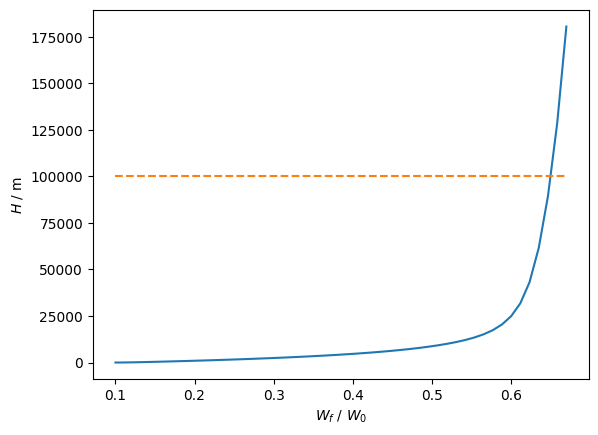

In [5]:
c_D = 0.04
S = 40

h_max = []

for i in range(len(Wf2W0)):
    h_max.append(simulation(W0[i], Wf2W0[i], m_dot[i], c_D, S))
    
plt.plot(Wf2W0, h_max)
karman = 100000 * np.ones(len(Wf2W0))
plt.plot(Wf2W0, karman, "--")

plt.ylabel("$H$ / $\mathrm{m}\; $")
plt.xlabel("$W_f$ / $W_0$")

plt.show()

In [6]:
print(Wf2W0[48], h_max[48])

0.6583673469387754 128403.91793776989


# Chosen Values
Assume $W_e \; / \; W_0 = 0.65$ we get

In [7]:
Wf2W0 = 0.65
W0 = calc_W0(Wf2W0)
T = calc_T(W0)
m_dot = calc_m_dot(T)
t_burn  = W0*Wf2W0 / m_dot
W_Fu = W0*Wf2W0/(1 + O2F)

print("W_0   :  {:.3f} kg".format(round(W0, 3)))
print("T     : {:.3f} N".format(round(T, 3)))
print("m_dot :     {:.3f} kg/s".format(round(m_dot, 3)))
print("t_burn:     {:.3f} s".format(round(t_burn, 3)))
print(30*"-")
print("W_f   :   {:.3f} kg".format(W0 * Wf2W0))
print("W_Fu  :    {:.3f} kg".format(W_Fu))
print("W_Fu  :   {:.3f} kg".format(W_Fu*O2F))

W_0   :  10000.000 kg
T     : 196200.000 N
m_dot :     79.984 kg/s
t_burn:     81.266 s
------------------------------
W_f   :   6500.000 kg
W_Fu  :    802.469 kg
W_Fu  :   5697.531 kg


# Influence of C_D
Investigating the influence of C_D in the rangeo 0.1 ... 0.5

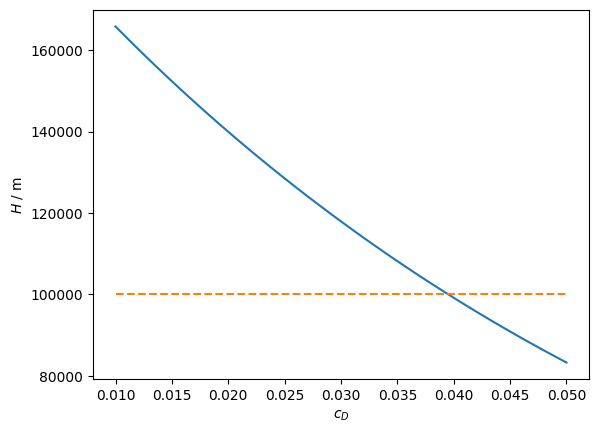

In [8]:
c_D = np.linspace(0.01, 0.05)
S = 40

h_max = []

for c in c_D:
    h_max.append(simulation(W0, Wf2W0, m_dot, c, S))
    
plt.plot(c_D, h_max)
karman = 100000 * np.ones(len(c_D))
plt.plot(c_D, karman, "--")

plt.ylabel("$H$ / $\mathrm{m}\; $")
plt.xlabel("$c_D$")

plt.show()

In [9]:
print(c_D[36], h_max[36])
print(c_D[37], h_max[37])
print("the critical value for c_D is 0.04")

0.03938775510204082 100241.78218760106
0.040204081632653065 98827.26805765297
the critical value for c_D is 0.04
